# Simulation et Monte Carlo

In [1]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

## Données angulaires 

Une loi classique pour des données correspondant à des angles observés sur l’intervalle [−π, π] est la loi de von Mises, de densité: $ π(θ) = \frac{1}{Z(κ)} exp(κ cos(θ − µ))$ où κ > 0, µ ∈ [−π, π], et Z(κ) est une constante de normalisation qui n’admet pas d’expression explicite. Cette loi est souvent qualifiée de loi normale pour les angles, car $cos(θ) ≈ 1 − θ^2$

### 1. Algorithme acceptation-rejet

In [2]:
def gen_uni_pi(n=1):
    return np.random.uniform(-np.pi, np.pi, n)

In [194]:
def unipi_density(x) :
    if x <= np.pi and x >= -np.pi:
        return 1/(2*np.pi)
    else:
        return 0
    
v_unipi_density = np.vectorize(unipi_density)

def von_mises_density(x, mu=0, kappa=1):
    return np.exp(kappa * np.cos(x - mu)) * (-np.pi <= x <= np.pi)

v_von_mises_density = np.vectorize(von_mises_density)

In [4]:
y = np.linspace(-np.pi, np.pi)

M = np.max(von_mises_density(y, mu=0, kappa=1)/v_unipi_density(y))

In [10]:
M

17.044412870709813

In [11]:
def von_mises_ra(M, mu=0, kappa=1):
    while True :
        x = gen_uni_pi()
        u = rd.random()
        if u <= (1/M)*von_mises_density(x)/(unipi_density(x)):
            return x 

<AxesSubplot:>

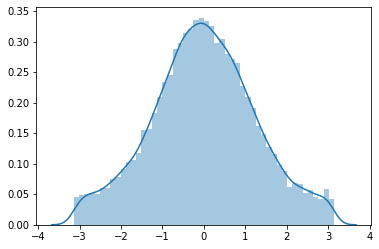

In [6]:
sns.distplot([von_mises_ra() for i in range(20000)])

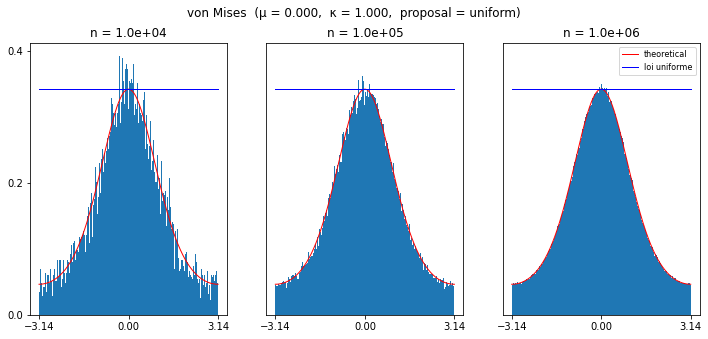

In [196]:
n = [10_000, 100_000, 1_000_000]
x = np.linspace(-np.pi, np.pi, 300)
mu = 0
kappa = 1 

fig, ax = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
i = 0

for val in n:
    
    M = np.max(v_von_mises_density(x, mu=0, kappa=1)/v_unipi_density(x))
    
    res = [von_mises_ra(M,kappa,mu)[0] for i in range(val)]
    
    ax[i].hist(res, bins=200, density=True)
    
    ax[i].plot(x, vonmises.pdf(x, kappa, mu), 'r-', lw=1, label='theoretical')


    ax[i].plot([-np.pi, np.pi], 2 * [vonmises.pdf(x, kappa, mu).max()], 'b-', lw=1, label='loi uniforme')

    ax[i].set_ylim([0., None])
    ax[i].set_xticks([-3.14, 0., 3.14])
    ax[i].title.set_text(f'n = {val:.1e}')
    
    i += 1

ax[0].locator_params(axis="y", nbins=4)
ax[1].get_yaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)

fig.suptitle(f'von Mises  (\u03BC = {mu:.3f},  \u03BA = {kappa:.3f},  proposal = uniform)')
plt.legend(prop={'size': 8})
plt.show()

### Performance en fonction de kappa et mu

In [20]:
def von_mises_unif_acceptance(kappa=1., mu=0,  n=100_000):
    """ This function estimates the acceptance rate according to a uniform distribution
    as proposal distribution.

    :param float kappa: kappa
    :param int n: number of simulations

    :return float: estimation of the acceptance rate in percentage
    """

    # Compute a uniform on [-pi, pi]
    sample = gen_uni_pi(n=n)
    sample = sample - mu

    # Compute the value for the rejection test
    val = np.exp(kappa * (np.cos(sample) - 1))

    # Acceptance step
    von_mises = sample[np.random.uniform(0, 1, n) <= val]
    return 100 * von_mises.shape[0] / n

In [21]:
von_mises_unif_acceptance(kappa=1, n= 100000)

46.615

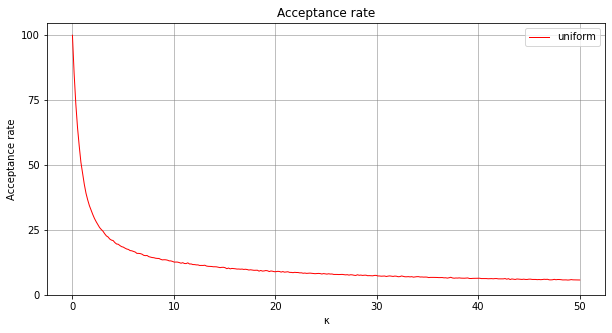

In [19]:
# Plot 

kappa = np.linspace(0, 50, 300)
n = 100000

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(kappa, [von_mises_unif_acceptance(kappa=val, n=n) for val in kappa], 'r-', lw=1, label='uniform')
ax.set_yticks([0, 25, 50, 75, 100])
ax.grid(True, linewidth=0.5, color='grey', linestyle='-')
ax.set_xlabel("\u03BA")
ax.set_ylabel("Acceptance rate")
ax.set_title("Acceptance rate")
plt.legend()
plt.show()

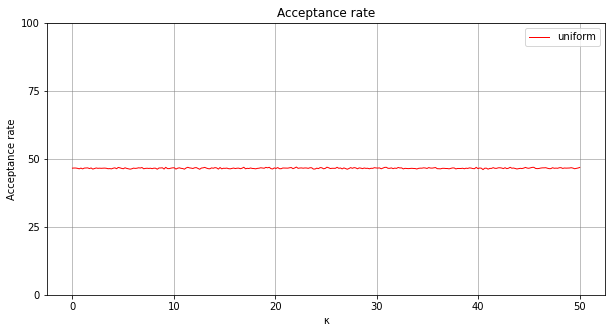

In [23]:
kappa1 = 1
mu = np.linspace(0, 50, 300)
n = 100000

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(kappa, [von_mises_unif_acceptance(kappa1, mu=val,n=n) for val in mu], 'r-', lw=1, label='uniform')
ax.set_yticks([0, 25, 50, 75, 100])
ax.grid(True, linewidth=0.5, color='grey', linestyle='-')
ax.set_xlabel("\u03BA")
ax.set_ylabel("Acceptance rate")
ax.set_title("Acceptance rate")
plt.legend()
plt.show()

### 2. Algorithme de Metropolis

Proposer un algorithme de Metropolis simple pour simuler selon une telle loi; notamment proposer une règle simple pour que 
la performance de l’algorithme ne dépende pas des paramètres. 
(Expliquer ce que veut dire le mot “performance” pour un tel algorithme.)

Contrairement à l'algorithme de rejet, MCMC crée des va qui ne sont pas indépendantes les unes des autres

In [230]:
def metropolis(x, sig= 3, mu=0, kappa=1):
    y = x + sig * np.random.randn()
    r = von_mises_density(y, mu, kappa) / von_mises_density(x, mu, kappa)
    if np.random.rand() < r:
        return (y,1) 
    else:
        return (x,0)

In [231]:
N = 100_000
mu = 0
kappa = 10
sig = 0.3
N_acceptance = 0
x = np.empty(N)
x[0] = 0
for i in range(1,N):
    res = metropolis(x[i-1], sig, mu, kappa)
    x[i] = res[0]
    N_acceptance += res[1]
    
print(N_acceptance/N)

0.72218


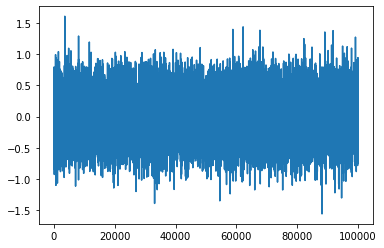

In [232]:
plt.plot(x)

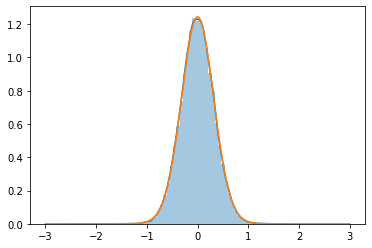

In [233]:
sns.distplot(x)
from scipy import stats
xx = np.linspace(-3,3, 1000)
plt.plot(xx, vonmises.pdf(xx, kappa, mu))

In [ ]:
def fit(self, len_batch=1000, num_iter=1000, min_rate=0.25, max_rate=0.3):
        """
        Chooses an optimal value for sigma, the standard deviation of our random walk. Keep in mind when choosing
        parameters that the number of simulation that will be computed is len_batch * num_iter.

        :param int len_batch: number of simulations for each Von Mises estimation.
        :param int num_iter: number of sigma that we want to try.
        :param float min_rate: lower bound for the acceptance rate.
        :param float max_rate: upper bound for the acceptance rate.
        :return float sig: the advised value for sigma.
        """

    old_sig = self.sig  # Stocks the value of sigma initially entered by user.
    step = 10 / num_iter
    sigma_proposals = [step * i for i in range(1, num_iter)]

    for i in range(num_iter):
        sig = sigma_proposals[i]
        self.sig = sig
        self.simulate(len_batch, verbose=False)

        if min_rate < self.acceptance_rate < max_rate:
            print(f'Recommended value for sigma : {sig}\nAcceptance rate around {self.acceptance_rate:.1%}')
            print(f'{i} iterations to find a fitting value\n')
            return sig

    self.sig = old_sig  # In order not to modify the sigma value wished by the user.
    print("Couldn't find a sigma that satisfies the acceptance rate criteria\n")
    return None

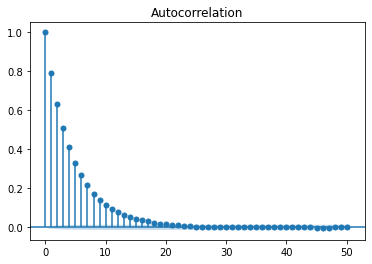

In [234]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(x)

plt.show()